## Figures for Network model of Latent Recurrent Discharge (LRD)


### Some imports and settings


In [1]:
SAVE_FIGS = True  # see save_args above for configuration
DOWNLOAD_CACHE = False  # if you want the cache files (~30 GB), set to True instead of running simulations again

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import warnings

import brian2.numpy_ as np
import matplotlib.pyplot as plt

from settings import COLOR, G_GABA_LIST, TAU_KCC2_LIST, constants, logging, time_unit

# start from defaults before loading stylesheet
plt.style.use("default")
plt.style.use("style/article.mplstyle")

# suppress warnings
np.seterr(all="ignore")
warnings.filterwarnings("ignore")

logger = logging.getLogger("lrd")

save_args = dict(use_args=False, close=False, file_formats=["svg", "jpg"])

In [4]:
if DOWNLOAD_CACHE:
    %pip install git+https://github.com/ChrisCurrin/dropbox-downloader.git
    import dropbox

    dropbox.downloadFile("https://www.dropbox.com/sh/noqzojddijvvs2a/AAD8ppgjSyi7QIcoGu0e3Ylba?dl=0", ".", unzip=True, retain_zip=False)


# Explain figure


In [42]:
mv_step = 4  # normally 2 mV
time_per_value = 20  # this is shorter than in paper (60 s)
egaba = [-74, -38]  # [start, stop)

diff = egaba[1] - egaba[0]
values = diff // mv_step
steps = values - 1
duration = values * time_per_value

print(f"EGABA range = {np.linspace(egaba[0], egaba[1], steps+2)[:-1]}")

EGABA range = [-74. -70. -66. -62. -58. -54. -50. -46. -42.]


In [ ]:
from scripts.lrdfigure_explain import Explain

np.random.seed(1337)

explain = Explain()

mv_step = 6 # normally 2 mV
time_per_value = 60  # this is shorter than in paper (60 s)
egaba = [-74, -38]  # [start, stop), normally [-74, -40]
# useful to have the difference between the two values to
# be a multiple of the mv_step

diff = egaba[1] - egaba[0]
values = diff // mv_step
steps = values - 1
duration = values * time_per_value

ehco3 = -18
phco3 = 0.2
pcl = 1 - phco3
ecl = [round((e - phco3 * ehco3) / pcl, 2) for e in egaba]

print(f"EGABA range = {np.linspace(egaba[0], egaba[1], steps+2)[:-1]}")

explain.run(
    duration=duration,
    num_ecl_steps=steps,
    E_Cl_0=ecl[0],
    E_Cl_end=ecl[-1],
    # cache=True, # note that this is imperfectly implemented currently
)
explain.plot()
if SAVE_FIGS:
    explain.save_figure(**save_args)
explain

# Alter conductances

1. Emulate picrotoxin (pink) by **reducing** $g_{GABA_{max}}$.
2. Emulate benzodiazepines (green) by **increasing** $g_{GABA_{max}}$.

We can see the effect of benzodiazepines depends on $E_{GABA}$.


2023-08-05 10:07:15 [    INFO] loading from cache                                                                         (core.lrdfigure::lrdfigure.py::437)
2023-08-05 10:07:15 [    INFO] loading temp/a69135c9f04852819724e2d3f11c9daf.h5                                           (core.lrdfigure::lrdfigure.py::452)
2023-08-05 10:07:17 [    INFO] loaded ['drug', 'E_Cl_0', 'run_idx', 'var'] ((600000, 189)) from cache temp/a69135c9f04852819724e2d3f11c9daf.h5 (core.lrdfigure::lrdfigure.py::455)
2023-08-05 10:07:17 [    INFO] plotting                                                                                   (scripts.lrdfigure_drugs::lrdfigure_drugs.py::72)
2023-08-05 10:07:17 [    INFO] drug = 0 	 ecl = -88.0                                                                     (scripts.lrdfigure_drugs::lrdfigure_drugs.py::211)
2023-08-05 10:07:17 [    INFO] drug = 0.25 	 ecl = -88.0                                                                  (scripts.lrdfigure_drugs::lrdfigure_dr

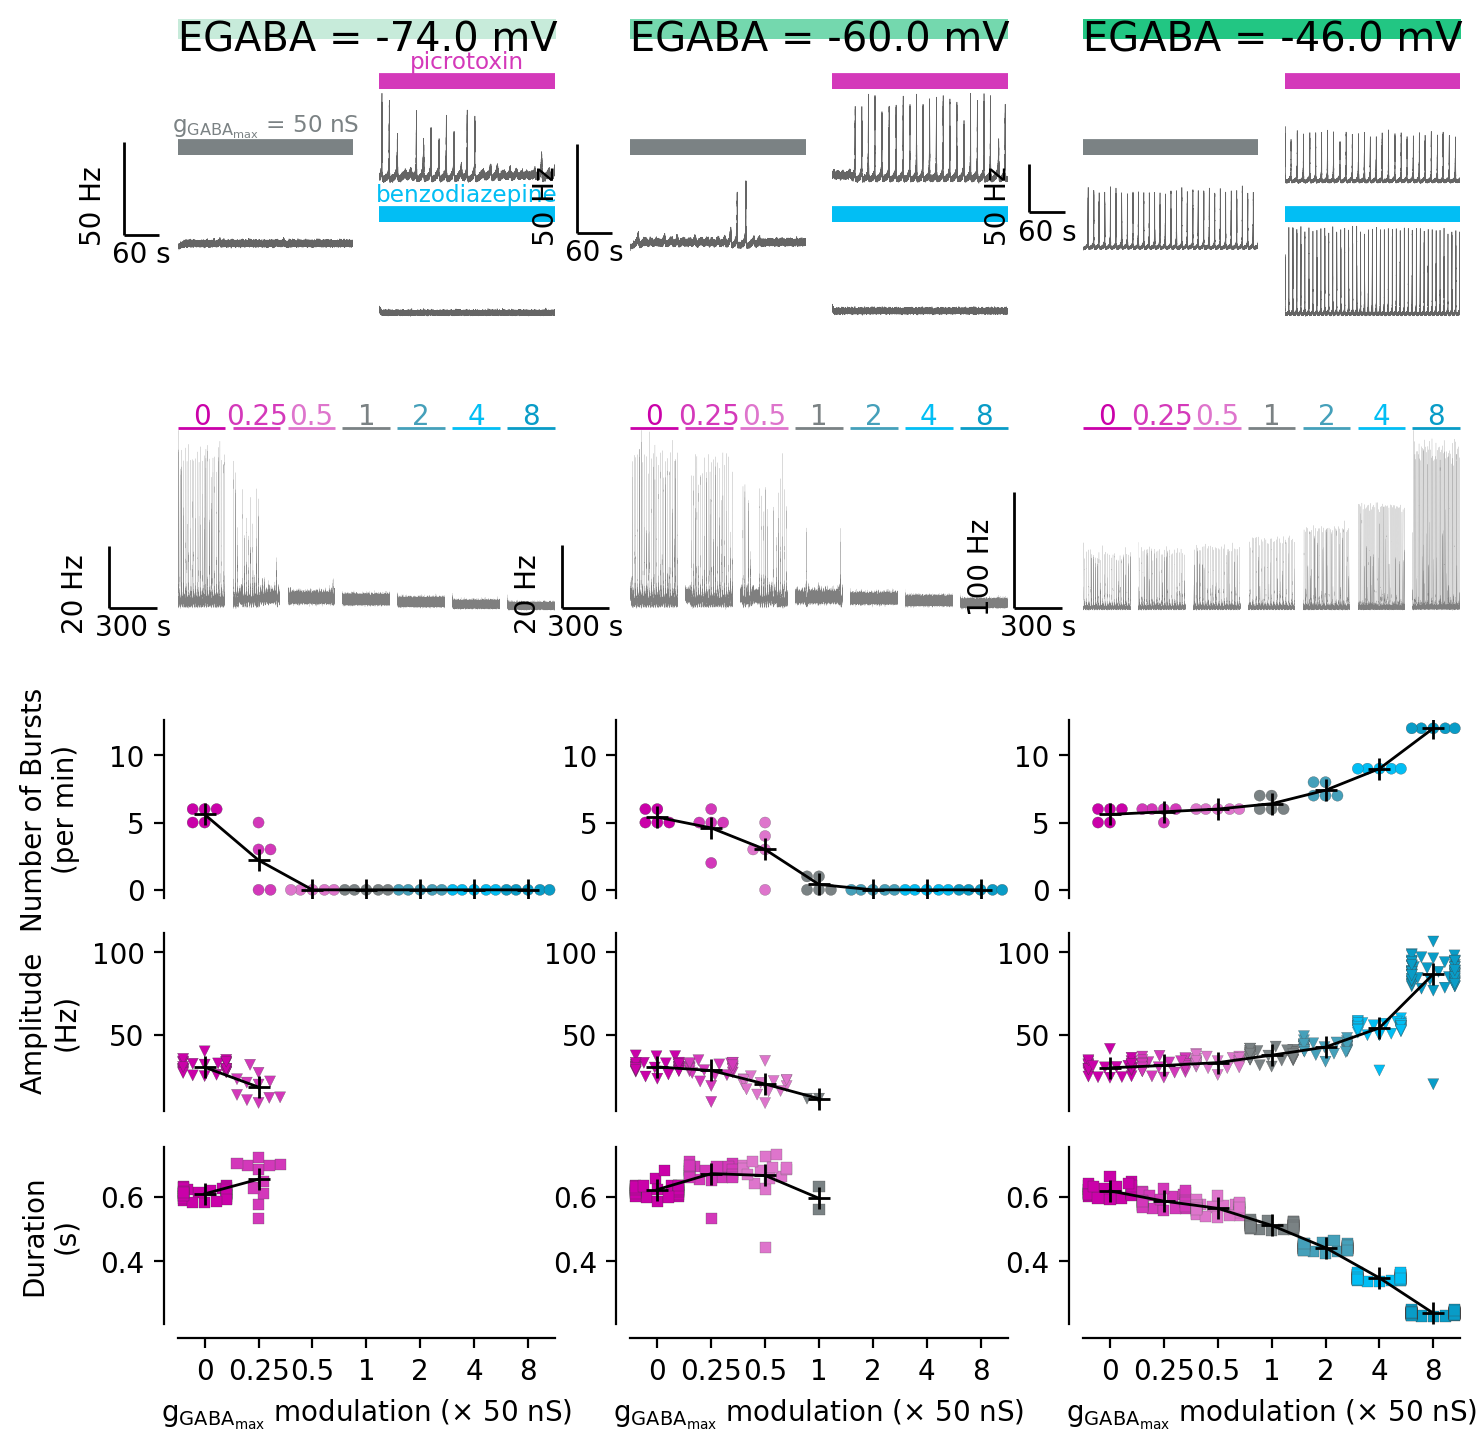

In [5]:
from scripts.lrdfigure_drugs import Drugs

ehco3 = -18
phco3 = 0.2
pcl = 1 - phco3
egabas = [-74, -60, -46]
E_Cl_0s = [round((e - phco3 * ehco3) / pcl, 2) for e in egabas]
drugs = Drugs(benzo_strengths=(0, 0.25, 0.5, 1, 2, 4, 8), E_Cl_0s=E_Cl_0s)
drugs.run()
drugs.plot(drugs_to_plot=[0.25, 4])
if SAVE_FIGS:
    drugs.save_figure(**save_args)

## Start having dynamic chloride $Cl^-$

We compared networks with either hyperpolarised ($\approx E_{GABA} = -74 mV$) or depolarised ($ \approx E_{GABA} = -46 mV$) EGABA.

The starting $E_{GABA}$ seems to have neglible, if any effect.

We further consider the effect of GABA conductance $g_{GABA_{max}}$ (brightness, rows) along with different $\tau_{KCC2}$ values (hue, traces).


2023-08-05 10:08:59 [    INFO] loading from cache                                                                         (core.lrdfigure::lrdfigure.py::437)
2023-08-05 10:08:59 [    INFO] loading temp/80681d4bfa953ccdcccf6adf7e8ae637.h5                                           (core.lrdfigure::lrdfigure.py::452)


2023-08-05 10:09:13 [    INFO] loaded ['$g_{GABA_{max}}$', '$\it{\tau}_{\rm{KCC2}}$', '$ECl\it{^-} _0$', 'run_idx', 'var'] ((600000, 960)) from cache temp/80681d4bfa953ccdcccf6adf7e8ae637.h5 (core.lrdfigure::lrdfigure.py::455)
2023-08-05 10:09:13 [    INFO] plotting                                                                                   (scripts.lrdfigure_chloride::lrdfigure_chloride.py::73)
Plotting state average: 4it [00:00, 56.22it/s]
Plotting state average: 4it [00:00, 44.60it/s]
Plotting state average: 4it [00:00, 35.03it/s]
Plotting state average: 4it [00:00, 30.72it/s]
Plotting state average: 4it [00:00, 55.48it/s]
Plotting state average: 4it [00:00, 43.22it/s]
2023-08-05 10:09:25 [    INFO] took 11.58s to plot                                                                        (scripts.lrdfigure_chloride::lrdfigure_chloride.py::552)
2023-08-05 10:09:25 [    INFO] saving figures                                                                             (core.lrdfig

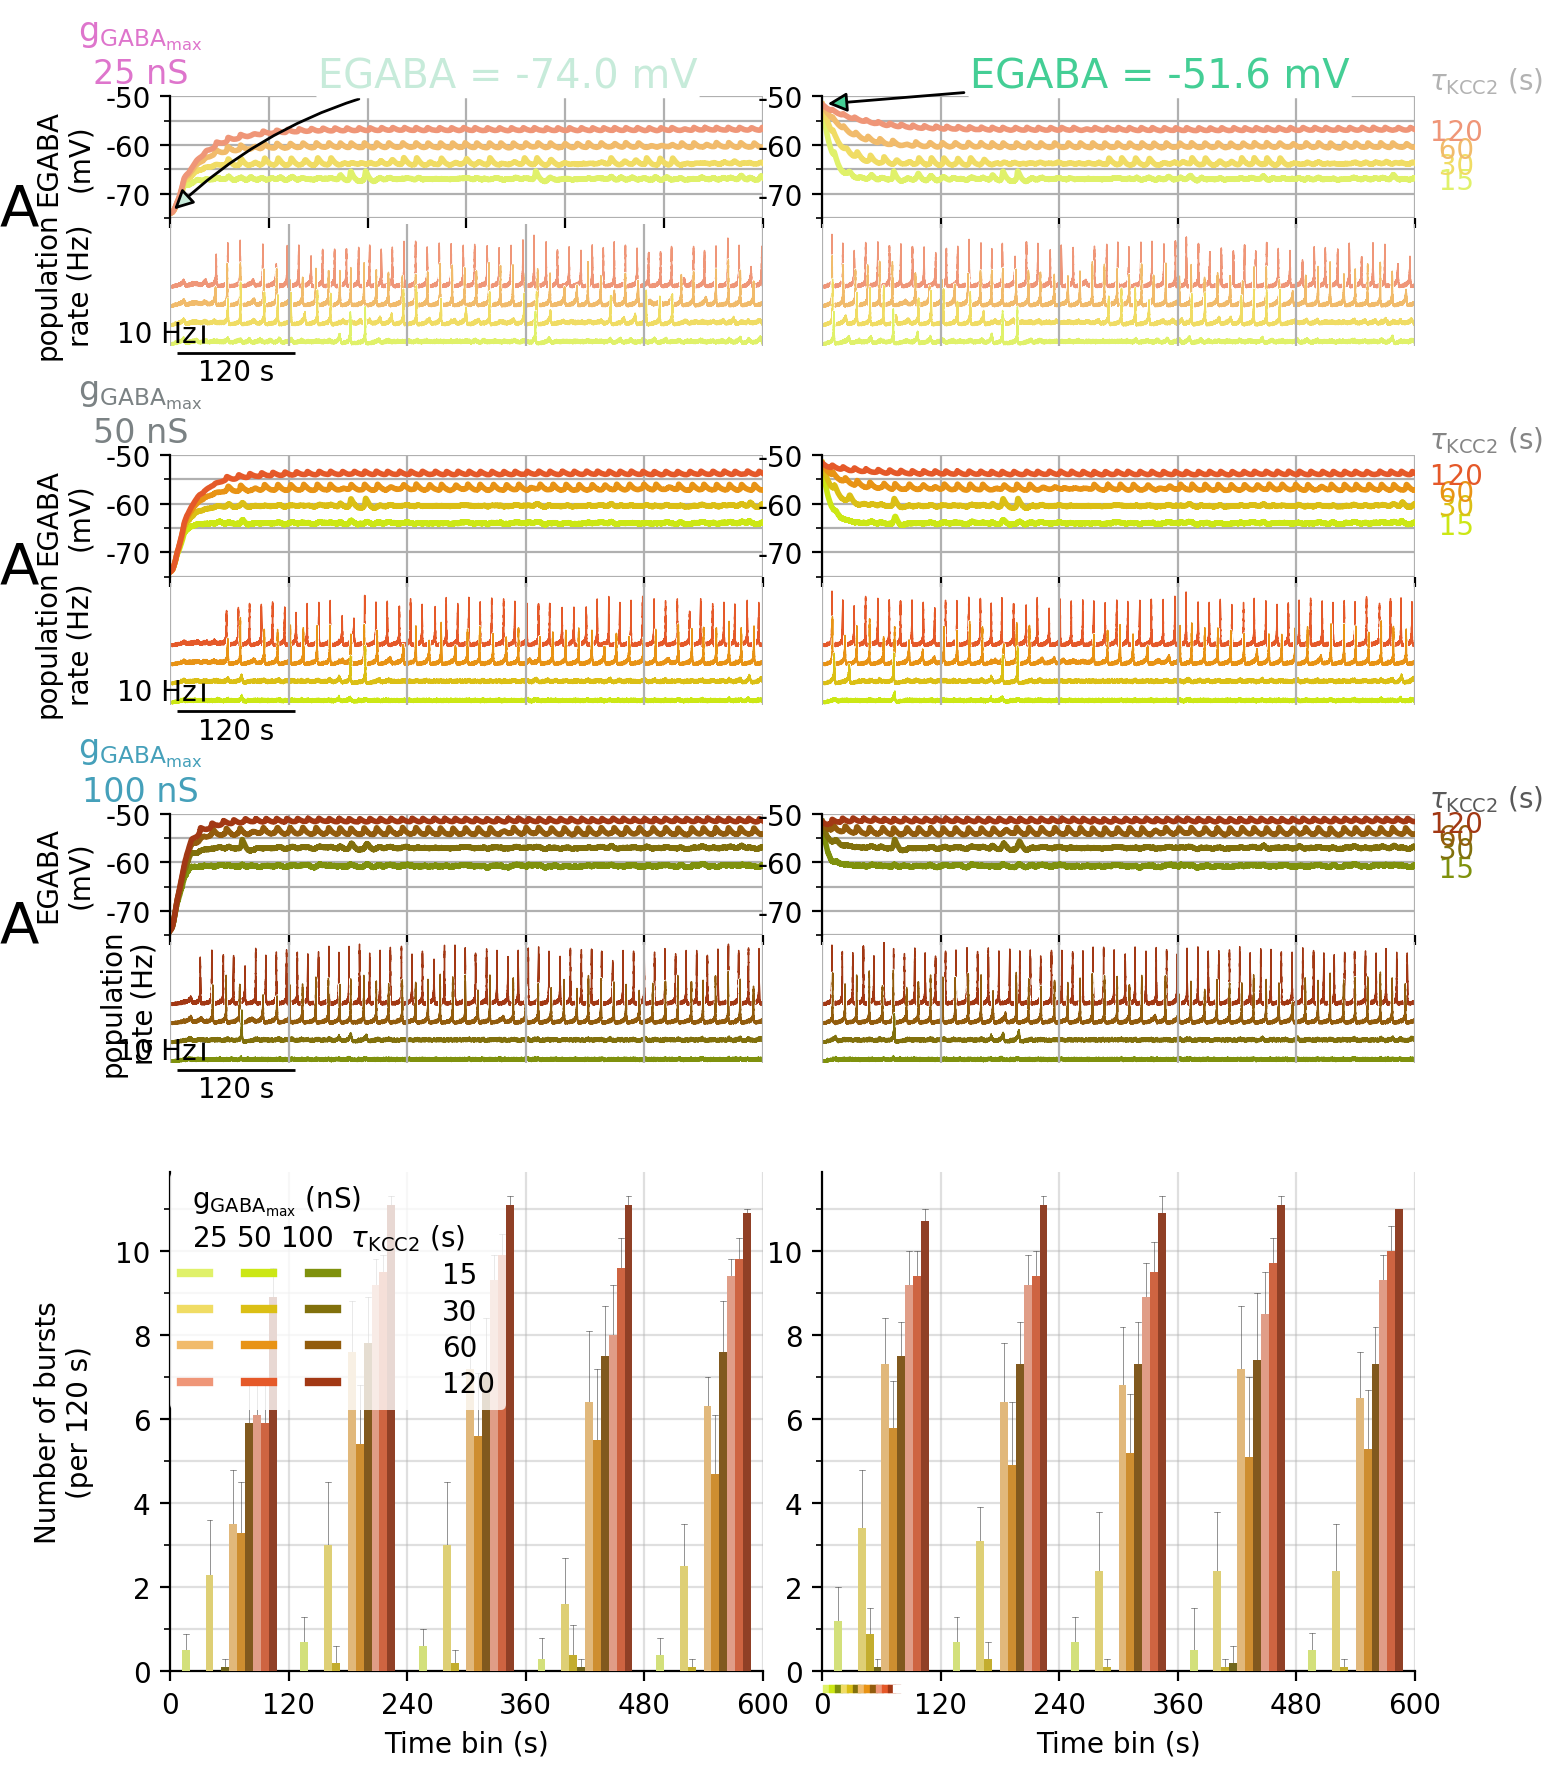

In [6]:
from scripts.lrdfigure_chloride import Chloride

cl = Chloride(
    tau_KCC2s=TAU_KCC2_LIST[::2][:-1],
    E_Cl_0s=(-60, -88),
    g_GABAs=(50, 25, 100),
    seeds=(None, 1038, 1337, 1111, 1010, 1011, 1101, 1110, 11110, 111100),
)
cl.run(duration=600)
cl.plot(timeit=True, colorbar=False)
if SAVE_FIGS:
    cl.save_figure(**save_args)
del cl

### Supplementary work: the effect of neuron size ($L$) and chloride extrusion ($\tau_{KCC2}$) on the number of bursts in a network


2023-08-05 10:09:39 [    INFO] loading from cache                                                                         (core.lrdfigure::lrdfigure.py::437)
loading files from cache:   0%|          | 0/225 [00:00<?, ?it/s]

loading files from cache: 100%|██████████| 225/225 [00:18<00:00, 12.46it/s]
2023-08-05 10:10:13 [    INFO] plotting                                                                                   (scripts.lrdfigure_chloride_length::lrdfigure_chloride_length.py::79)
Plotting state average: 5it [00:00, 56.90it/s]
Plotting state average: 5it [00:00, 57.11it/s]
Plotting state average: 5it [00:00, 56.25it/s]
Plotting state average: 5it [00:00, 58.84it/s]
Plotting state average: 5it [00:00, 58.62it/s]
Plotting state average: 5it [00:00, 58.65it/s]
Plotting state average: 5it [00:00, 58.30it/s]
Plotting state average: 5it [00:00, 59.16it/s]
Plotting state average: 5it [00:00, 58.95it/s]
2023-08-05 10:10:29 [    INFO] took 15.91s to plot                                                                        (scripts.lrdfigure_chloride_length::lrdfigure_chloride_length.py::557)
2023-08-05 10:10:29 [    INFO] saving figures                                                                       

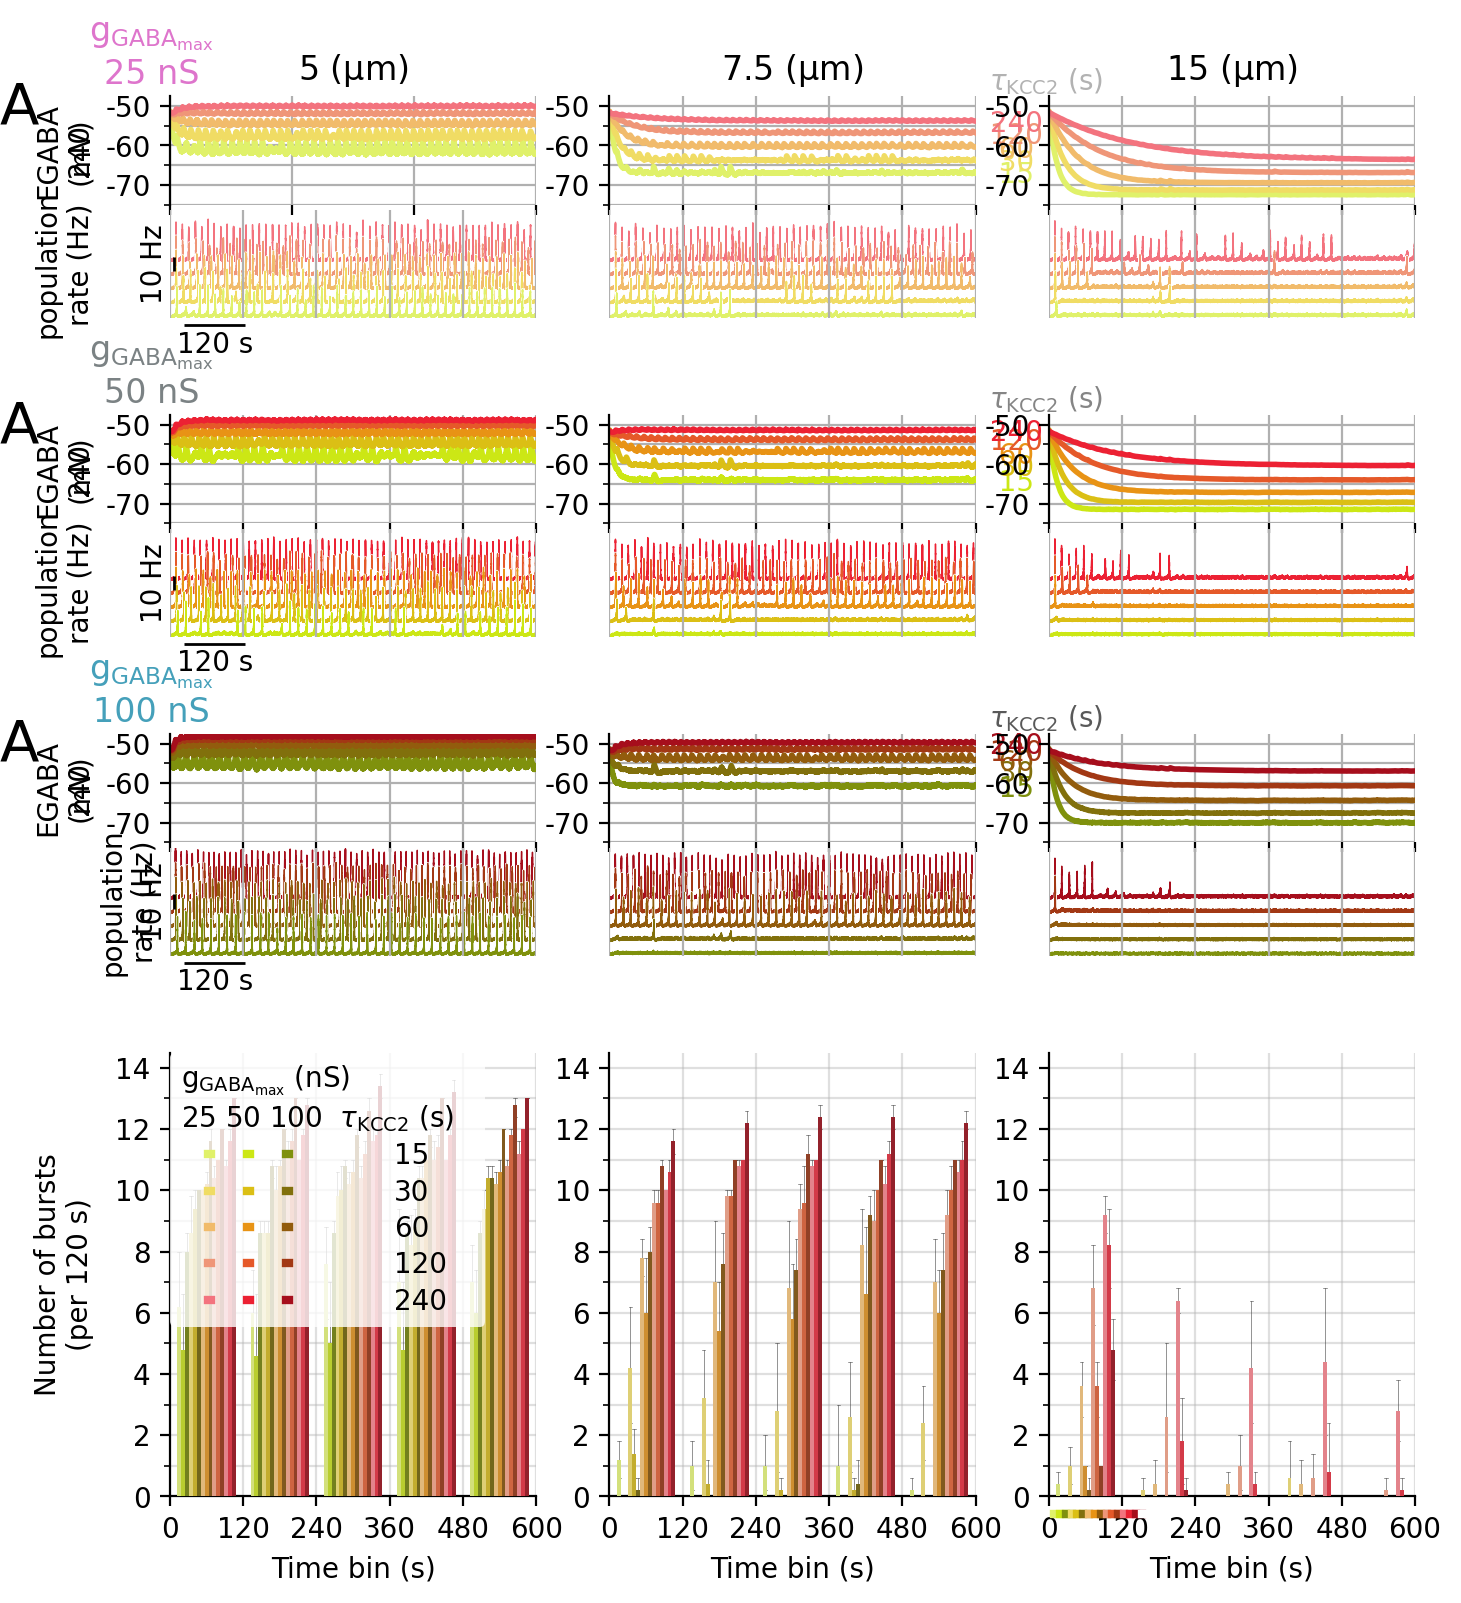

In [7]:
from scripts.lrdfigure_chloride_length import ChlorideLength

cl_length = ChlorideLength(
    g_GABAs=(50, 25, 100),
    lengths=(15, 
             #10, 
             7.5, 
             #6.25, 
             5),
    seeds=(
        None,
        1038,
        1337,
        1111,
        1234,
    ),
)

cl_length.run(duration=600)
cl_length.plot(timeit=True, colorbar=False)
if SAVE_FIGS:
    cl_length.save_figure(**save_args)

# Explore time constants of "Excitatory" and "Inhibitory" KCC2

$\tau_{KCC2_{exc}}$ = [15, 21, 30, 42, 60, 84, 120, 169, 240]

$\tau_{KCC2_{inh}}$ = [15, 21, 30, 42, 60, 84, 120, 169, 240]


2023-08-05 10:10:49 [    INFO] loading from cache                                                                         (core.lrdfigure::lrdfigure.py::437)
2023-08-05 10:10:49 [    INFO] loading temp/6abee4f55192b5fd4d57d45e9e531e20.h5                                           (core.lrdfigure::lrdfigure.py::452)


2023-08-05 10:11:13 [    INFO] loaded ['$g_{GABA_{max}}$', '$\it{\tau}_{\rm{KCC2_{PC}}}$', '$\it{\tau}_{\rm{KCC2_{IN}}}$', 'run_idx', 'var'] ((60000, 17010)) from cache temp/6abee4f55192b5fd4d57d45e9e531e20.h5 (core.lrdfigure::lrdfigure.py::455)
2023-08-05 10:11:13 [    INFO] Processing data                                                                            (scripts.lrdfigure_tau::lrdfigure_tau.py::108)
2023-08-05 10:12:54 [    INFO] Processed data                                                                             (scripts.lrdfigure_tau::lrdfigure_tau.py::207)
2023-08-05 10:12:54 [    INFO] plotting                                                                                   (scripts.lrdfigure_tau::lrdfigure_tau.py::752)
plotting rate traces (g_gaba): 2it [00:00,  7.52it/s]
plotting heatmaps (g_gaba=100): : 2it [00:03,  1.91s/it, formatting]
2023-08-05 10:12:58 [    INFO] saving figures                                                                             (c

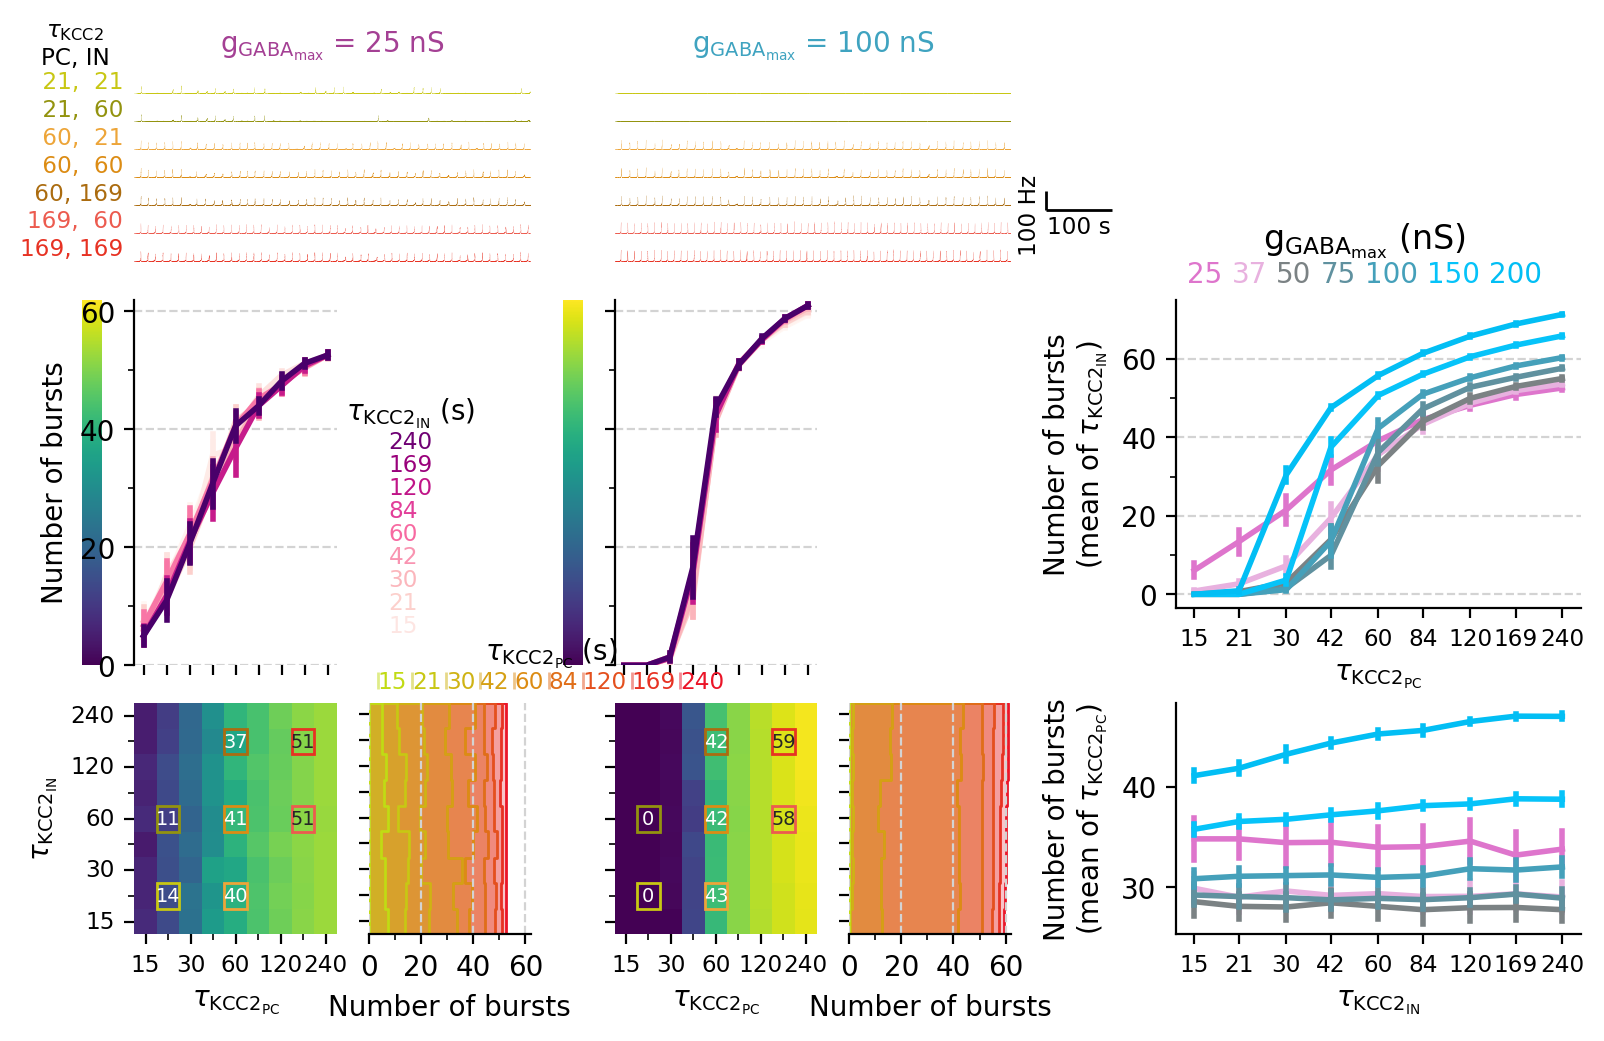

In [8]:
from scripts.lrdfigure_tau import Tau

tau = Tau(
    tau_KCC2_E_list=TAU_KCC2_LIST,
    tau_KCC2_I_list=TAU_KCC2_LIST,
    g_GABA_list=G_GABA_LIST + [37, 75, 150],
    seeds=(
        None,
        1038,
        1337,
        1111,
        1010,
    ),
)

tau.run(duration=600, nrn_idx_i=[0, 1, 2, 3])
(df_long, df_bursts_bins, df_taus, df_num_bursts) = tau.process_data()
tau.plot(
    plot_ggaba=[25, 100],
    df_num_bursts=df_num_bursts,
    vmax=df_num_bursts[df_num_bursts["g_GABA"].isin([25, 100])][
        "Number of bursts"
    ].max(),
)
if SAVE_FIGS:
    tau.save_figure(**save_args)

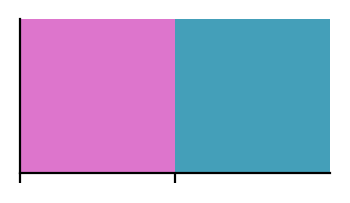

In [18]:
sns.palplot([COLOR.G_GABA_SM.to_rgba(25), COLOR.G_GABA_SM.to_rgba(100)])

2023-08-05 10:13:00 [    INFO] plotting                                                                                   (scripts.lrdfigure_tau::lrdfigure_tau.py::219)


2023-08-05 10:14:28 [    INFO] took 88.48s to plot                                                                        (scripts.lrdfigure_tau::lrdfigure_tau.py::739)


(Tau({"g_GABA_max": {"range": [25, 50, 100, 200, 37, 75, 150], "title": "$g_{GABA_{max}}$"}, "tau_KCC2_E": {"range": [15, 21, 30, 42, 60, 84, 120, 169, 240], "title": "$\\it{\\tau}_{\\rm{KCC2_{PC}}}$"}, "tau_KCC2_I": {"range": [15, 21, 30, 42, 60, 84, 120, 169, 240], "title": "$\\it{\\tau}_{\\rm{KCC2_{IN}}}$"}}, seeds=(None, 1038, 1337, 1111, 1010)),
        run_idx  g_GABA  KCC2 E  KCC2 I  Burst start time (s)  \
 0          0.0    25.0    15.0    15.0                 11.24   
 1          0.0    25.0    15.0    15.0                 71.33   
 2          0.0    25.0    15.0    15.0                 96.04   
 3          0.0    25.0    15.0    15.0                171.68   
 4          0.0    25.0    15.0    15.0                181.91   
 ...        ...     ...     ...     ...                   ...   
 95269      4.0   150.0   240.0   240.0                564.44   
 95270      4.0   150.0   240.0   240.0                573.13   
 95271      4.0   150.0   240.0   240.0                582.02 

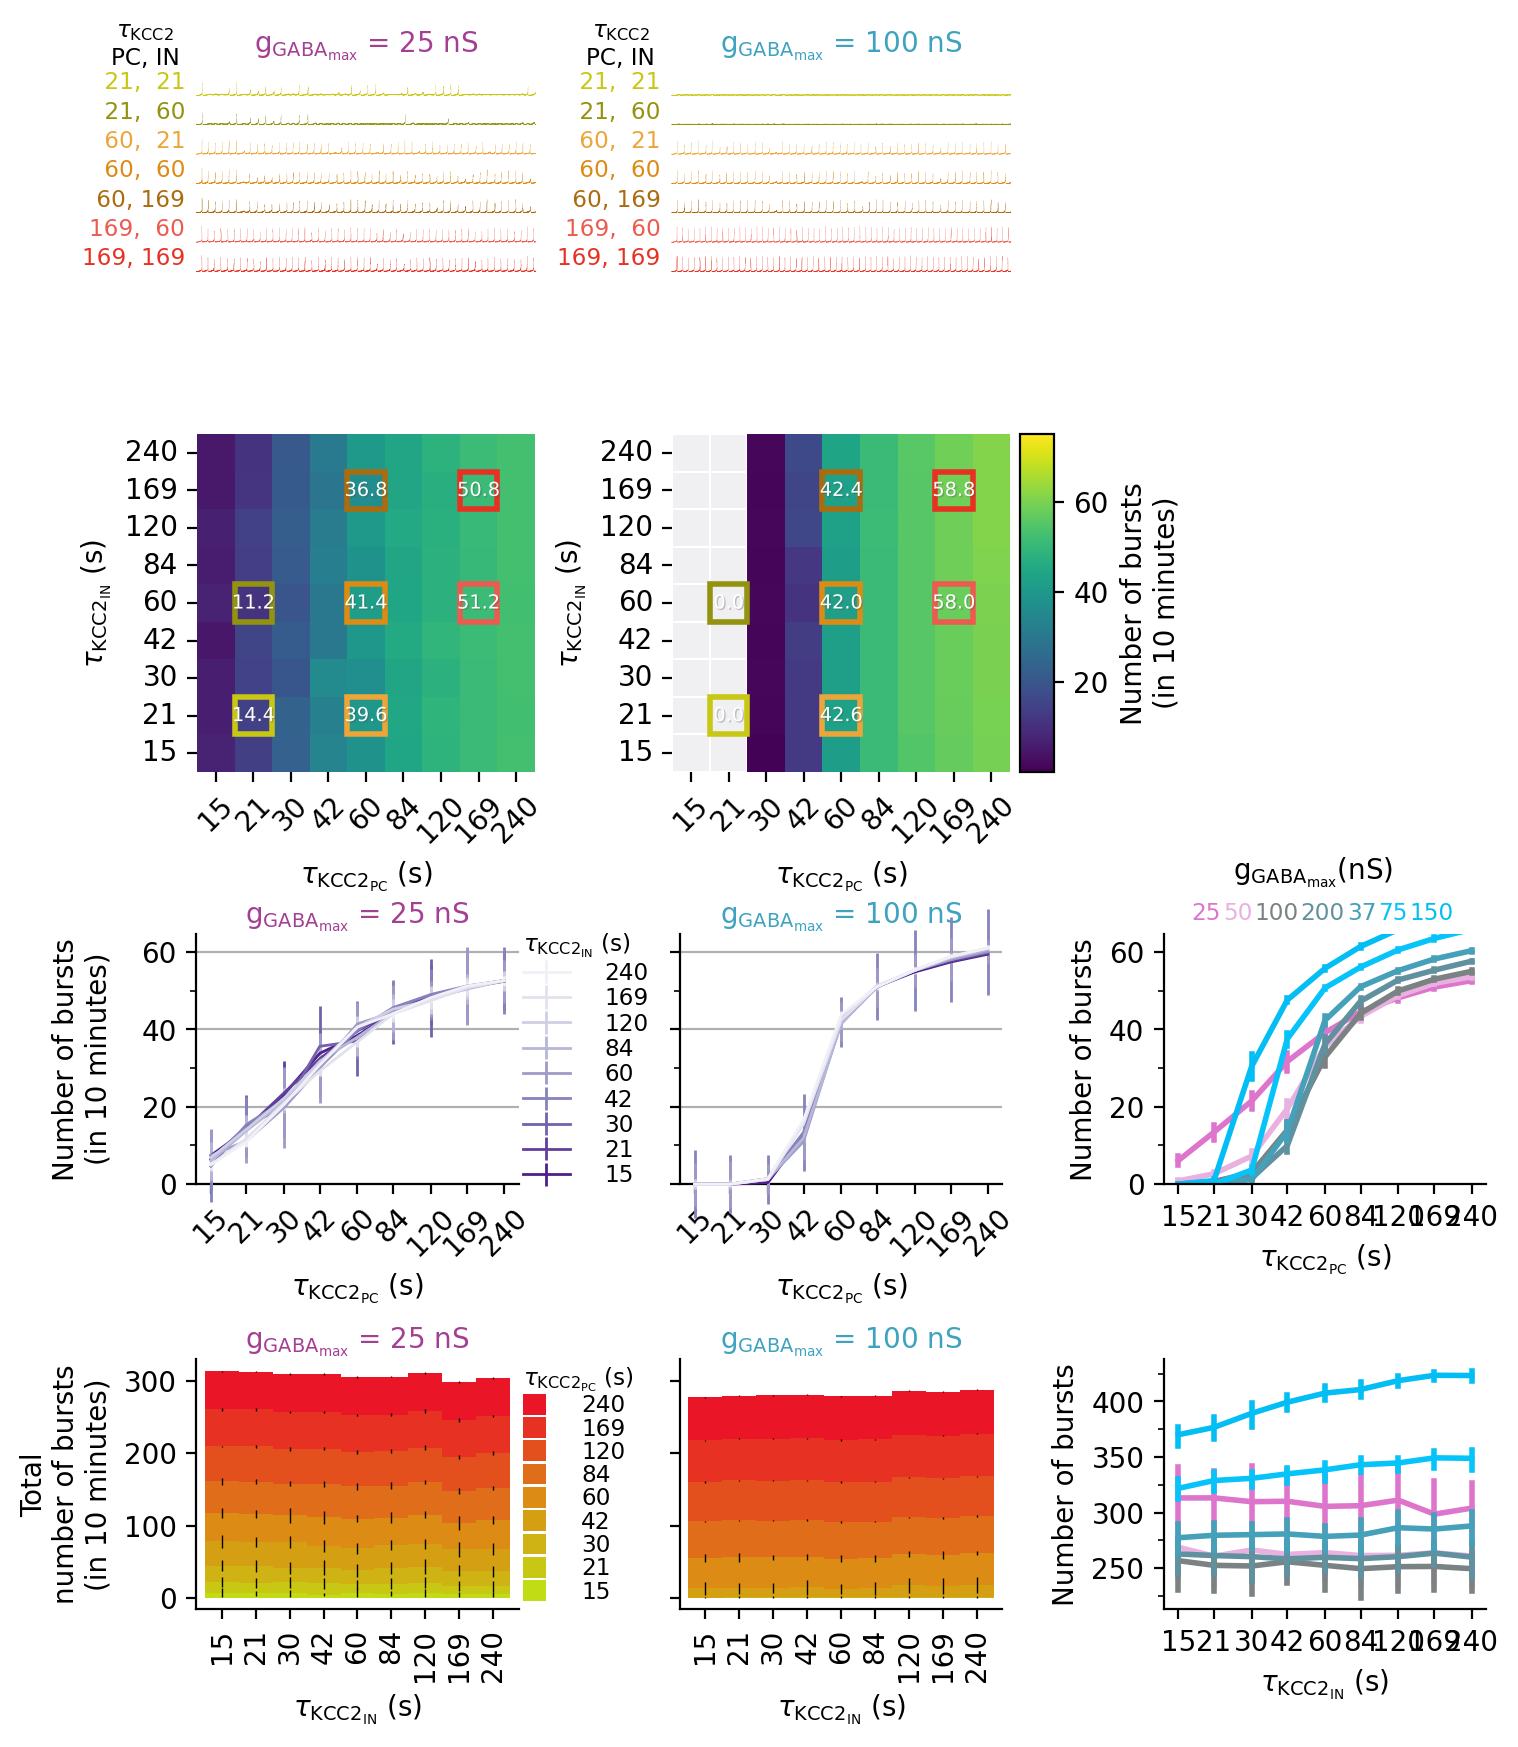

In [9]:
tau.plot_old(plot_g_GABA_list=[25, 100]);

## $g_{GABA_{max}}$ vs $\tau_{KCC2}$ with $E_{GABA}$

First, plot number of bursts as a function of $g_{GABA_{max}}$ as we directly vary $E_{GABA}$ (static $Cl^-$).

Next, plot number of bursts and $E_{GABA}$ as a function of $g_{GABA_{max}}$ and $\tau_{KCC2}$.

Finally, plot the relationship between the pre-burst GABAergic current ($I_{GABA}$) and the number of bursts. The $g_{GABA_{max}}$ and $\tau_{KCC2}$ are displayed for reference as color and marker size, respectively. Squares are from static simulations.


2023-08-05 10:14:30 [    INFO] PART 1
********************                                                                (scripts.lrdfigure_ggaba_e::lrdfigure_ggaba_e.py::72)
2023-08-05 10:14:30 [    INFO] loading from cache                                                                         (core.lrdfigure::lrdfigure.py::437)
2023-08-05 10:14:30 [    INFO] loading temp/dfbc7147ef9f133eea6ccec16d2790f6.h5                                           (core.lrdfigure::lrdfigure.py::452)


2023-08-05 10:15:03 [    INFO] loaded ['$g_{GABA_{max}}$', 'run_idx', 'var'] ((1020000, 1710)) from cache temp/dfbc7147ef9f133eea6ccec16d2790f6.h5 (core.lrdfigure::lrdfigure.py::455)
2023-08-05 10:15:03 [    INFO] PART 2 
********************                                                               (scripts.lrdfigure_ggaba_e::lrdfigure_ggaba_e.py::104)
2023-08-05 10:15:03 [    INFO] loading from cache                                                                         (core.lrdfigure::lrdfigure.py::437)
2023-08-05 10:15:04 [    INFO] loading temp/0bc5bd6fbc4f21ba27d637acee573fd9.hdf5                                         (core.lrdfigure::lrdfigure.py::447)
2023-08-05 10:15:04 [    INFO] loaded ['Time', 'E_GABA_E', 'E_GABA_I', 'E_GABA_all', 'I_GABA_E', 'I_GABA_I', 'I_GABA_all', 'g_GABA_E', 'g_GABA_I', 'r_all', '$g_{GABA_{max}}$', '$\\it{\\tau}_{\\rm{KCC2}}$', 'run_idx'] from cache temp/0bc5bd6fbc4f21ba27d637acee573fd9.hdf5 (core.lrdfigure::lrdfigure.py::449)
2023-08-05 10:15:

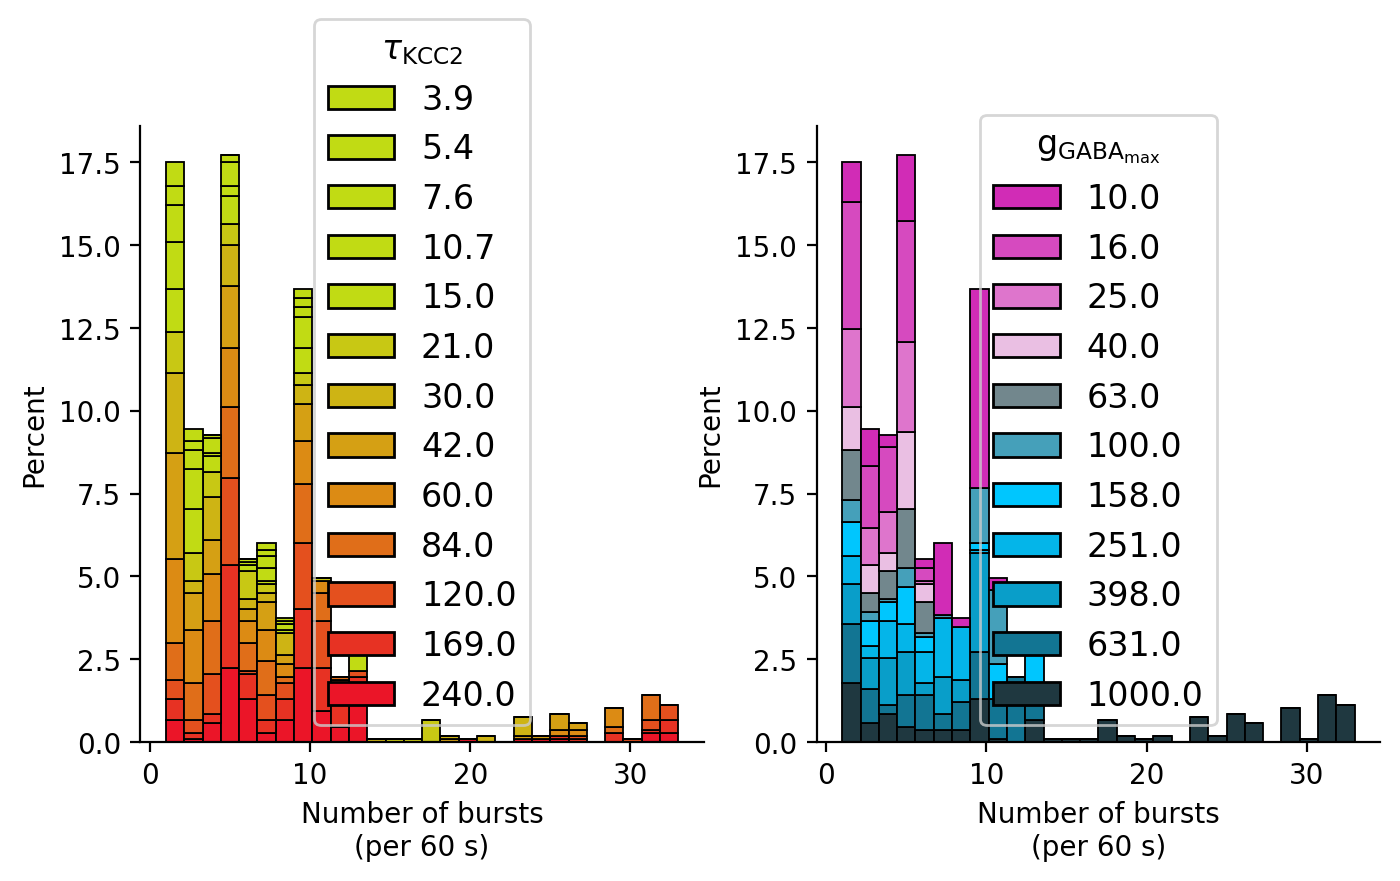

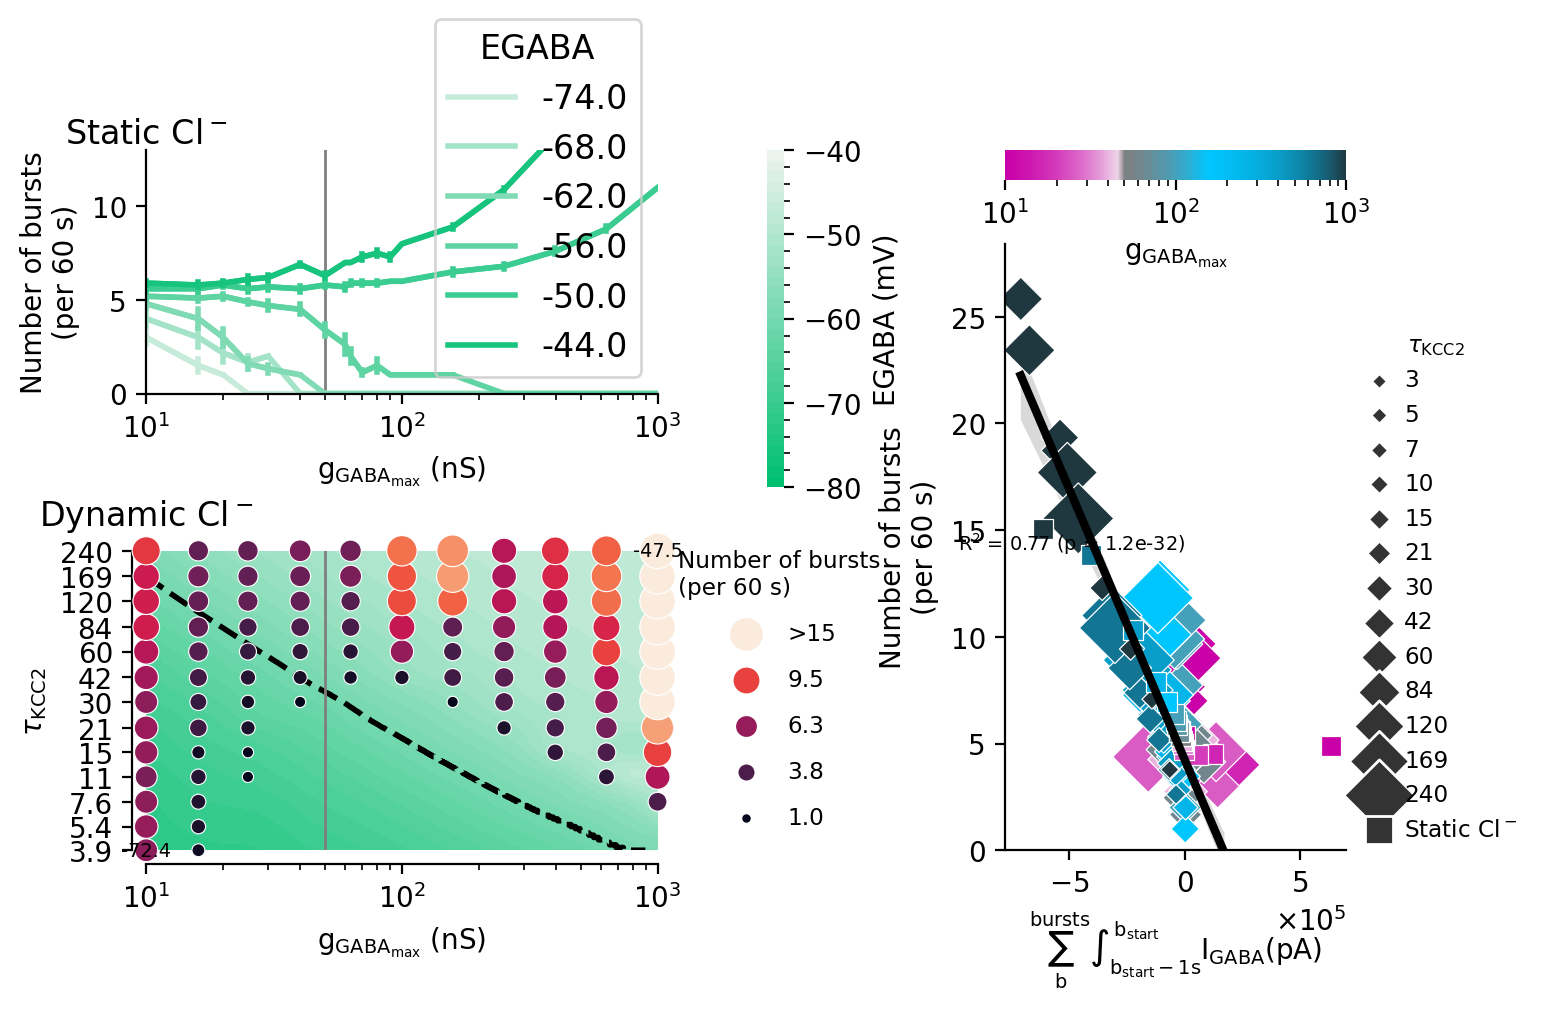

In [10]:
from scripts.lrdfigure_ggaba_e import Gve

# add some more lower values for tau
tau_KCC2_list = TAU_KCC2_LIST

ratio = tau_KCC2_list[1] / tau_KCC2_list[0]
tau_KCC2_list = [np.round(tau_KCC2_list[0] / ratio, 1)] + tau_KCC2_list
tau_KCC2_list = [np.round(tau_KCC2_list[0] / ratio, 1)] + tau_KCC2_list
tau_KCC2_list = [np.round(tau_KCC2_list[0] / ratio, 1)] + tau_KCC2_list
tau_KCC2_list = [np.round(tau_KCC2_list[0] / ratio, 1)] + tau_KCC2_list


gve = Gve(
    seeds=(None, 1234, 5678, 1426987, 86751, 1010, 876, 12576, 9681, 814265),
    gGABAsvEGABA=sorted(
        set(
            np.append(
                np.round(np.arange(0, 100.0001, 10), 0),
                np.geomspace(10, 1000, 11).round(0),
            )
        )
    ),
    gGABAs=np.geomspace(10, 1000, 11).round(0),
    tau_KCC2s=tau_KCC2_list,
)
gve.run()
gve.process()
import seaborn as sns

fig, axes = plt.subplots(ncols=2, figsize=(8,4))
sns.histplot(
    data=gve.df_g_tau_bursts,
    x="Number of bursts\n(per 60 s)",
    hue=constants.TAU_KCC2,
    multiple="stack",
    palette=COLOR.TAU_SM.cmap,
    hue_norm=COLOR.TAU_SM.norm,
    ax=axes[0],
    alpha=1,
    stat="percent",
)
sns.histplot(
    data=gve.df_g_tau_bursts,
    x="Number of bursts\n(per 60 s)",
    hue=constants.G_GABA,
    multiple="stack",
    palette=COLOR.G_GABA_SM.cmap,
    hue_norm=COLOR.G_GABA_SM.norm,
    ax=axes[1],
    alpha=1,
    stat="percent",
)

# most bursts are <= 15 so for visualisation, set this to the norm max
gve.plot(egabas=5, bursts_max=15)
if SAVE_FIGS:
    from style.figure import plot_save
    plot_save(f"output/{gve.fig_name}_supp.jpg", figs=[fig], close=False)
    gve.save_figure(figs=gve.figs, **save_args)

## Supplementary: investigate how excitatory parameters affect the number of bursts.

Specifically, we vary:

1. $g_{AMPA_{max}}$
2. $g_{NMDA_{max}}$

And run static $Cl^-$ simulations at hyperpolarised (blue), close to $V_{rest}$ (purple), and depolarised (red) EGABA values.


2023-08-05 10:15:13 [    INFO] loading from cache                                                                         (core.lrdfigure::lrdfigure.py::437)
2023-08-05 10:15:13 [    INFO] loading temp/23b3488f4179accceef86f2e62b4eebd.h5                                           (core.lrdfigure::lrdfigure.py::452)


2023-08-05 10:15:27 [    INFO] loaded ['$g_{GABA_{max}}$', '$g_{AMPA_{max}}$', '$g_{NMDA_{max}}$', 'run_idx', 'var'] ((1020000, 972)) from cache temp/23b3488f4179accceef86f2e62b4eebd.h5 (core.lrdfigure::lrdfigure.py::455)
processing bursts: 100%|██████████| 108/108 [00:36<00:00,  2.93it/s]
2023-08-05 10:16:04 [    INFO] plotting                                                                                   (scripts.lrdfigure_gampa::lrdfigure_gampa.py::191)
2023-08-05 10:16:06 [    INFO] plotting rate example                                                                      (scripts.lrdfigure_gampa::lrdfigure_gampa.py::205)
2023-08-05 10:16:17 [    INFO] saving figures                                                                             (core.lrdfigure::lrdfigure.py::274)
2023-08-05 10:16:17 [    INFO] saving to output/figure_s1_gampa_rates_example.svg                                         (plot_save::figure.py::64)
2023-08-05 10:16:22 [    INFO] Saved figures [2]        

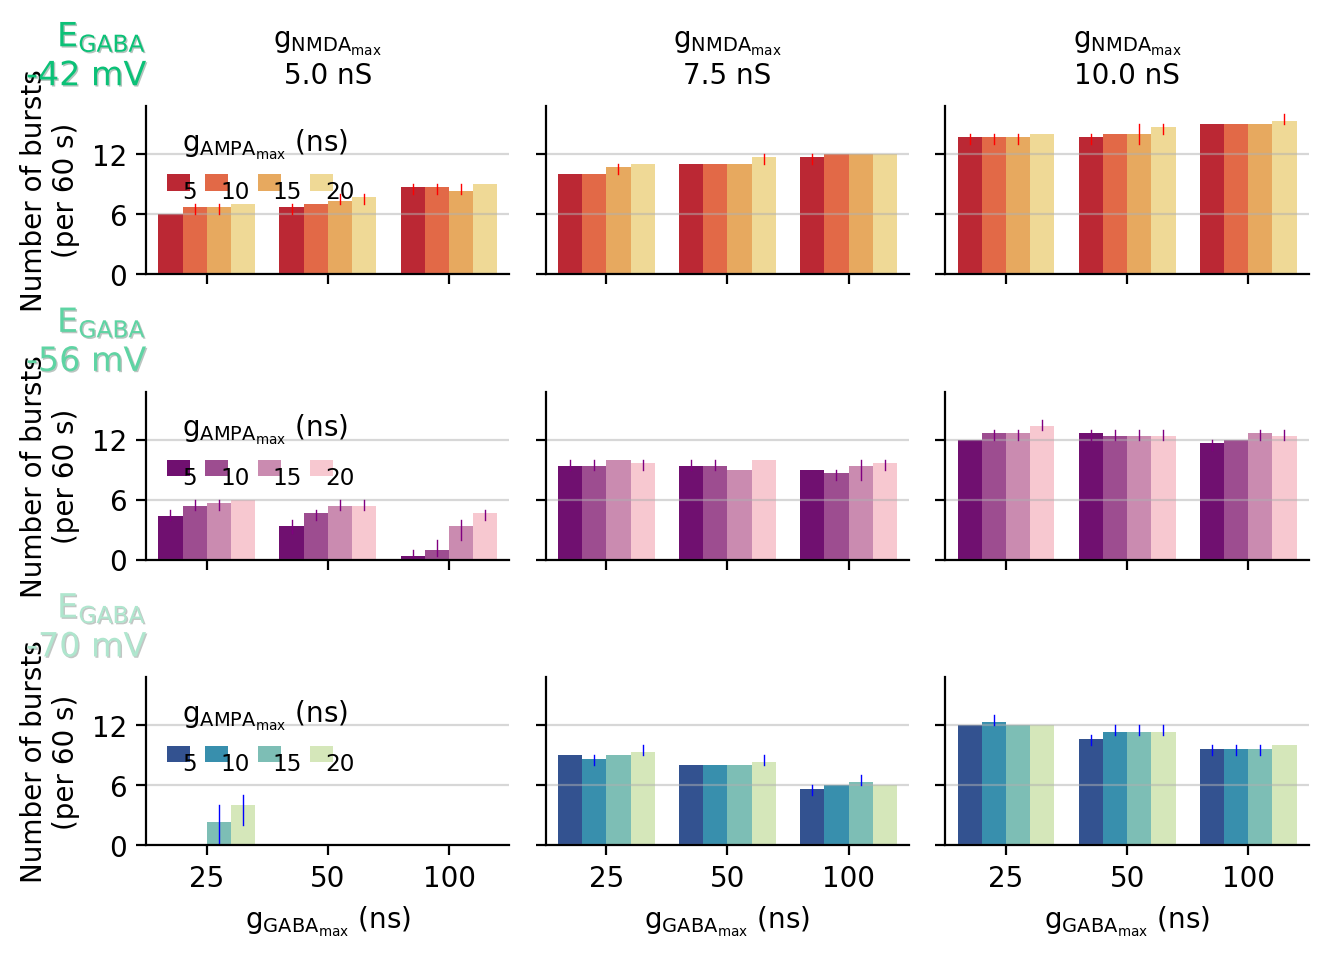

In [12]:
from scripts.lrdfigure_gampa import Params

exc_params = Params(
    gGABAs=[
        # 0,
        25,
        50,
        100,
        # 200,
    ],
    gAMPAs=np.round(np.arange(0, 20.0001, 5.0), 0),
    gNMDAs=[5.0, 7.5, 10.0],
    seeds=(
        None,
        1013,
        12987,
        #    1234, 1837
    ),
)
exc_params.run()
exc_params.process()
exc_params.plot(egabas=[-42, -56, -70])

if SAVE_FIGS:
    exc_params.save_figure(**save_args)

# Playground


`None` keeps default values (see `core.sim.py`)


In [13]:
from core.sim import single_run

net, results = single_run(
    N=None,
    duration=5*second,
    dt=None,  # Simulation params
    Mg2_t0=None,
    zero_mag_wash_rate=None,  # Seizure params
    benzo_onset_t=None,
    benzo_wash_rate=None,
    benzo_strength=None,
    benzo_off_t=None,  # drug params
    p=None,
    p_ee=None,
    p_ei=None,
    p_ie=None,
    p_ii=None,  # Connection params
    w=None,
    w_ee=None,
    w_ei=None,
    w_ie=None,
    w_ii=None,  # weight params
    U_0=None,
    tau_d=None,
    tau_f=None,  # STP params
    g_AMPA_max=None,
    g_NMDA_max=None,
    g_GABA_max=None,  # conductances
    E_Cl_0=None,
    E_Cl_target=None,
    E_Cl_end=None,
    E_Cl_pop=None,  # ECl params
    length=None,  # neuron params
    dyn_cl=None,
    manual_cl=None,  # dynamic/manual arg
    tau_KCC2_E=None,
    tau_KCC2_I=None,
    num_ecl_steps=None,  # dynamic + manual params
    __build=True,
    __save_run=False,
    __monitors=None,
    nrn_idx_i=None,  # Brian2 args
    run_seed=None,
    __plot=True,
    __device_directory=None,
)

NameError: name 'second' is not defined